In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch

%load_ext autoreload
%autoreload 2

In [2]:
from survshares.datasets import Rossi, Metabric, GBSG2

# Prepare dataset
dataset = Metabric()
dataset.load(normalise=False)
X_train, X_test, T_train, T_test, E_train, E_test = dataset.split()

In [3]:
from survshares.metrics import negative_pll 
from gplearn.gplearn.fitness import make_fitness

def fitness_npll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = negative_pll(y_true, y_pred, sample_weight)
    result = pll + 0.05 * np.abs(y_pred).mean()
    if np.isinf(result):
        result = np.inf # Cover -inf with +inf
    return result


fitness_npll_shrink = make_fitness(
    function=fitness_npll_shrink, greater_is_better=False
)

In [4]:
import wandb 
run = wandb.init(
    project="shares_risk_study",
    config={
        "dataset": "metabric",
        "fitness": "npll_shrink",
        "epochs": 5,
        "generations": 5,
    }
)

wandb: Currently logged in as: steliosbl (steliosbl-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
from gplearn.gplearn.model import ShapeNN
from survshares.symbolic_regressor import SurvSymbolicRegressor
from survshares.loss import approximateNpllLoss, npllLoss
from survshares.base_symbolic import BaseSurvSymbolic
from survshares.program import SurvProgram

survival_params = {
    "program_class": SurvProgram,
    "population_size": 2,
    "generations": 2,
    "tournament_size": 10,
    "function_set": ("add", "mul", "div", "shape"),
    "logging_console": True,
    "logging_wandb": True,
    "wandb_run": run,
    "random_state": 42,
    "const_range": None,
    "n_jobs": 1,
    "p_crossover": 0.4,
    "p_subtree_mutation": 0.2,
    "p_point_mutation": 0.2,
    "p_hoist_mutation": 0.05,
    "p_point_replace": 0.2,
    "parsimony_coefficient": 0.0,
    "metric": fitness_npll_shrink,
    "parsimony_coefficient": 0.0,
    "optim_dict": {
        "alg": "adam",
        "lr": 1e-2,  # tuned automatically
        "max_n_epochs": 100,
        "tol": 1e-3,
        "task": "survival",
        "device": "cpu",
        "batch_size": 1000,
        "shape_class": ShapeNN,
        "constructor_dict": {
            "n_hidden_layers": 5,
            "width": 10,
            "activation_name": "ELU",
        },
        "num_workers_dataloader": 0,
        "seed": 42,
        "checkpoint_folder": Path("data/checkpoints/survshare_rossi"),
        "keep_models": True,
        "loss_fn": approximateNpllLoss(),
    },
}

model = SurvSymbolicRegressor(**survival_params, categorical_variables=dataset.categorical_values)

In [14]:
model.fit(torch.Tensor(X_train), torch.Tensor(T_train), torch.Tensor(E_train))

/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
None -> None -> add(shape(div(add(X8, mul(X0, X7)), mul(X6, shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))


`Trainer.fit` stopped: `max_epochs=100` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


1
Min error so far: 6.900145053863525
None -> None -> mul(mul(div(shape(X1), X4), div(X6, X2)), shape(mul(X5, X0)))
mul(mul(div(shape(X1), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-27T13.51.55 exists and is not empty.
`Trainer.fit` stopped: `max_epochs=100` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


mul(mul(div(shape(X1), shape(X4)), div(shape(X6), X2)), shape(mul(shape(X5), X0)))


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2
Min error so far: 6.900145053863525
Best program: add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3))
   0    16.00          6.95727       16          6.90015              N/A     14.09s
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Point Mutation -> add(shape(div(add(X8, mul(X0, shape(X7))), add(shape(X6), shape(X5)))), shape(X3))
add(shape(div(add(X8, mul(X0, shape(X7))), add(shape(X6), shape(X5)))), shape(X3))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-27T13.51.55 exists and is not empty.
`Trainer.fit` stopped: `max_epochs=100` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(shape(div(add(X8, mul(X0, shape(X7))), add(shape(X6), shape(X5)))), shape(X3))


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


3
Min error so far: 6.900145053863525
add(shape(div(add(X8, mul(X0, shape(X7))), mul(shape(X6), shape(X5)))), shape(X3)) -> Subtree Mutation -> add(add(mul(X4, X6), shape(add(X5, shape(mul(X7, div(div(shape(X1), shape(X2)), X0)))))), shape(X3))
add(add(mul(shape(X4), shape(X6)), shape(add(shape(X5), shape(mul(shape(X7), div(div(shape(X1), shape(X2)), X0)))))), shape(X3))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs/data/checkpoints/survshare_rossi/2025-05-27T13.51.55 exists and is not empty.
`Trainer.fit` stopped: `max_epochs=100` reached.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(add(mul(shape(X4), shape(X6)), shape(add(shape(X5), shape(mul(shape(X7), div(div(shape(X1), shape(X2)), X0)))))), shape(X3))


Predicting: |          | 0/? [00:00<?, ?it/s]

4
Min error so far: 6.900145053863525
Best program: add(shape(div(add(X8, mul(X0, shape(X7))), add(shape(X6), shape(X5)))), shape(X3))
   1    20.00          6.96806       16          6.90537              N/A      0.00s


SurvSymbolicRegressor(categorical_variables={4: (0, 1), 5: (0, 1), 6: (0, 1),
                                             7: (0, 1)},
                      const_range=None,
                      function_set=('add', 'mul', 'div', 'shape'),
                      generations=2, logging_wandb=True,
                      metric=<gplearn.gplearn.fitness._Fitness object at 0x7f3fed2ffe90>,
                      optim_dict={'alg': 'adam', 'batch_size': 1000,
                                  'checkpoint_folder': PosixPath('data/checkpoints/survshare_rossi'),
                                  'constru...
                                  'num_workers_dataloader': 0, 'seed': 42,
                                  'shape_class': <class 'gplearn.gplearn.model.ShapeNN'>,
                                  'task': 'survival', 'tol': 0.001},
                      p_crossover=0.4, p_hoist_mutation=0.05,
                      p_point_mutation=0.2, p_point_replace=0.2,
                      p_subtree_mutation=0.2, parsimony_coefficient=0.0,
                      population_size=2, random_state=42, tournament_size=10,
                      wandb_run=<wandb.sdk.wandb_run.Run object at 0x7f3fc7619250>)

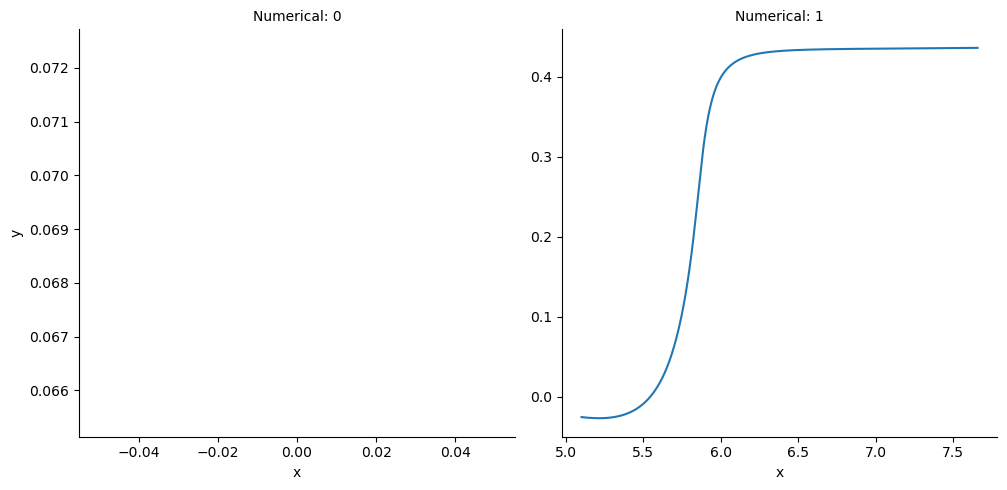

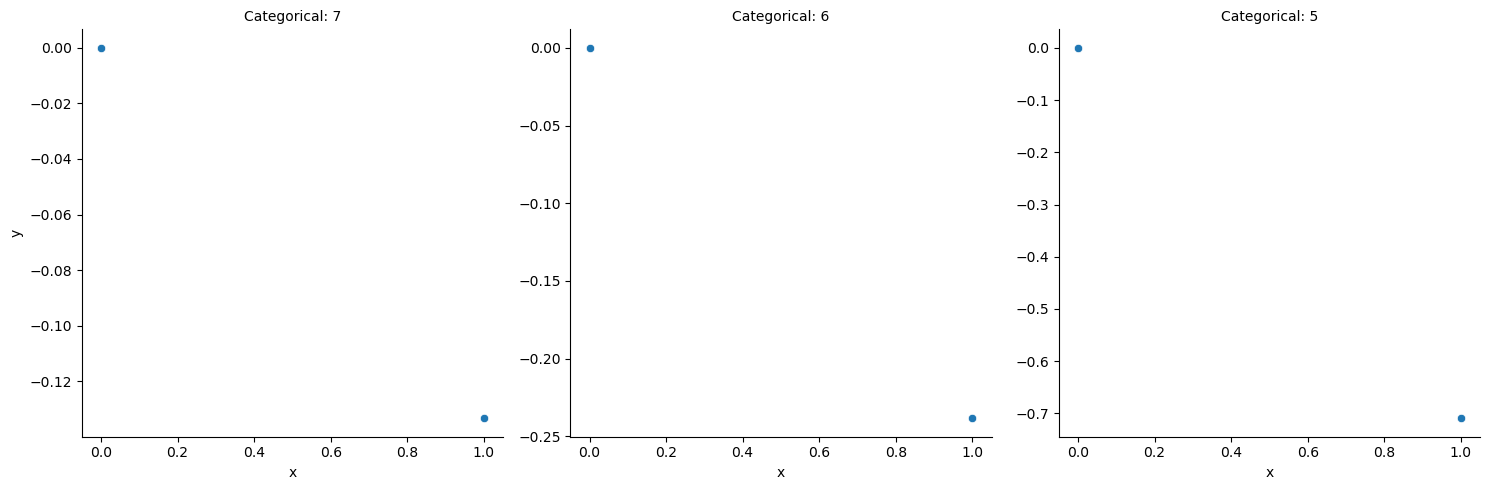

In [15]:
model._program.plot_shape_functions(
    dataset.numerical_ranges,
    dataset.categorical_values
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

{'mean_absolute_difference_binned': np.float64(0.08630027654499448),
 'mean_absolute_difference_smoothed': np.float64(0.42269698379324966),
 'median_absolute_difference_binned': np.float64(0.06803096605880991),
 'median_absolute_difference_smoothed': np.float64(0.42711126581261416)}

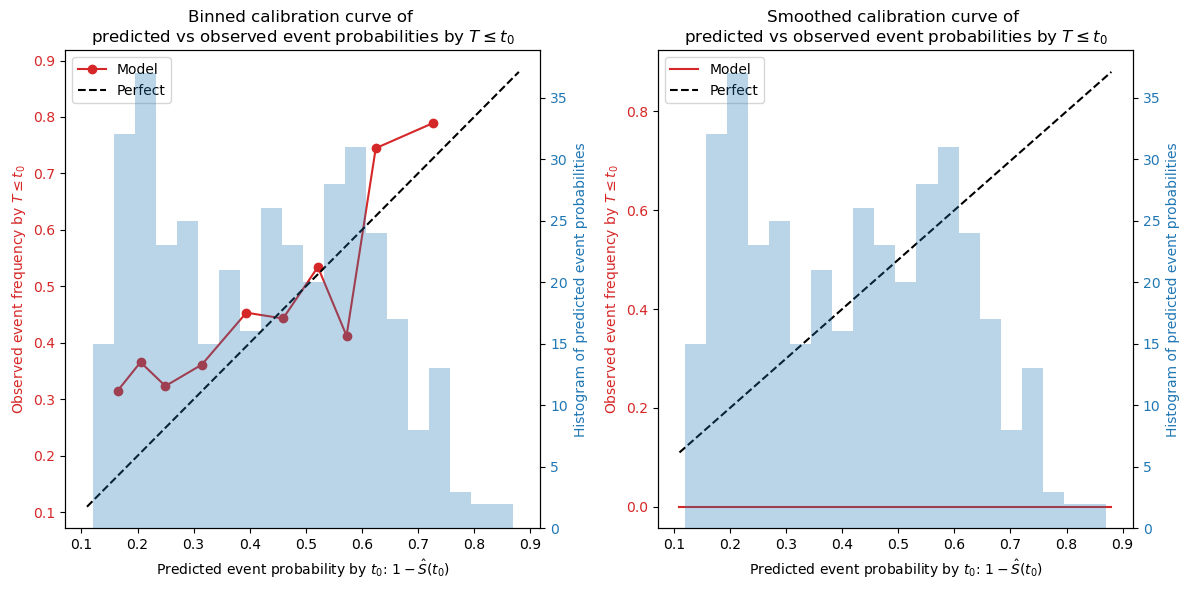

In [ ]:
from survshares.hazard_model import HazardModel 

hm = HazardModel(model, dataset.categorical_values).prepare_estimands(X_train, T_train, E_train)
hm.score(torch.Tensor(X_test), torch.Tensor(T_test), torch.Tensor(E_test))
hm.plot_calibration(torch.Tensor(X_test), torch.Tensor(T_test), torch.Tensor(E_test), t0=np.unique(T_train)[len(T_train)//2])